# Catboost predictor - One-hot encoded
Implemented version of the catboost model predictor model with one-hot encoding

In [1]:
# import basic libraries
import pandas as pd

# import machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#import catboost
from catboost import CatBoostRegressor

In [3]:
#import the data
X_train = pd.read_csv("data/generated/onehot/X_train.csv")
y_train = pd.read_csv("data/generated/onehot/y_train.csv")
X_test = pd.read_csv("data/generated/onehot/X_test.csv")
y_test = pd.read_csv("data/generated/onehot/y_test.csv")

### Pre-process the data

In [4]:
#Saving the data into csv adds the numerical indexing
y_test = y_test['remaining_time']
y_train = y_train['remaining_time']

In [5]:
missing_columns = set(X_train.columns) - set(X_test.columns)
print("Missing columns:", missing_columns)

Missing columns: {'concept:name_W_Shortened completion ', 'concept:name_W_Personal Loan collection'}


In [6]:
columns_2_drop= ['Unnamed: 0', 'EventID',
        'time:timestamp',
       'case:concept:name', 'Selected']

In [7]:
# Drop the unnamed and lifecycle columns column
X_test = X_test.drop(columns_2_drop, axis=1)
X_train = X_train.drop(columns_2_drop + list(missing_columns), axis=1)

In [14]:
# Separate categorical and numeric features

categorical_features = ['org:resource', 
                  'EventOrigin',
                  'lifecycle:transition', 
                  'case:ApplicationType']
numeric_features = X_train.columns.difference(categorical_features)

# Convert categorical features to string
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

In [15]:
X_train.dtypes

org:resource                              object
EventOrigin                               object
lifecycle:transition                      object
case:ApplicationType                      object
case:RequestedAmount                     float64
FirstWithdrawalAmount                    float64
NumberOfTerms                            float64
MonthlyCost                              float64
CreditScore                              float64
OfferedAmount                            float64
event_index_in_trace                       int64
execution_time                           float64
Action_Created                             int64
Action_Deleted                             int64
Action_Obtained                            int64
Action_Released                            int64
Action_statechange                         int64
concept:name_A_Accepted                    int64
concept:name_A_Cancelled                   int64
concept:name_A_Complete                    int64
concept:name_A_Conce

### Building the model

In [16]:
# Create a CatBoost regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.01, loss_function='RMSE')

In [17]:
# Train the model
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 13.4808190	test: 11.9257778	best: 11.9257778 (0)	total: 313ms	remaining: 2m 36s
10:	learn: 13.1139638	test: 11.5424585	best: 11.5424585 (10)	total: 2.18s	remaining: 1m 36s
20:	learn: 12.7816279	test: 11.2112137	best: 11.2112137 (20)	total: 3.92s	remaining: 1m 29s
30:	learn: 12.5018778	test: 10.9227268	best: 10.9227268 (30)	total: 5.62s	remaining: 1m 25s
40:	learn: 12.2674285	test: 10.6799506	best: 10.6799506 (40)	total: 7.31s	remaining: 1m 21s
50:	learn: 12.0703998	test: 10.4800516	best: 10.4800516 (50)	total: 9.33s	remaining: 1m 22s
60:	learn: 11.9053759	test: 10.3176296	best: 10.3176296 (60)	total: 10.9s	remaining: 1m 18s
70:	learn: 11.7651981	test: 10.1780200	best: 10.1780200 (70)	total: 12.6s	remaining: 1m 16s
80:	learn: 11.6489607	test: 10.0629867	best: 10.0629867 (80)	total: 14.3s	remaining: 1m 13s
90:	learn: 11.5504137	test: 9.9668256	best: 9.9668256 (90)	total: 15.9s	remaining: 1m 11s
100:	learn: 11.4653113	test: 9.8879243	best: 9.8879243 (100)	total: 17.7s	remaining:

In [18]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [19]:
# MSE
mean_squared_error(y_test, y_pred)

88.3571220552873

In [20]:
# R2
r2_score(y_test, y_pred)

0.3800137789081499

### Feature importance

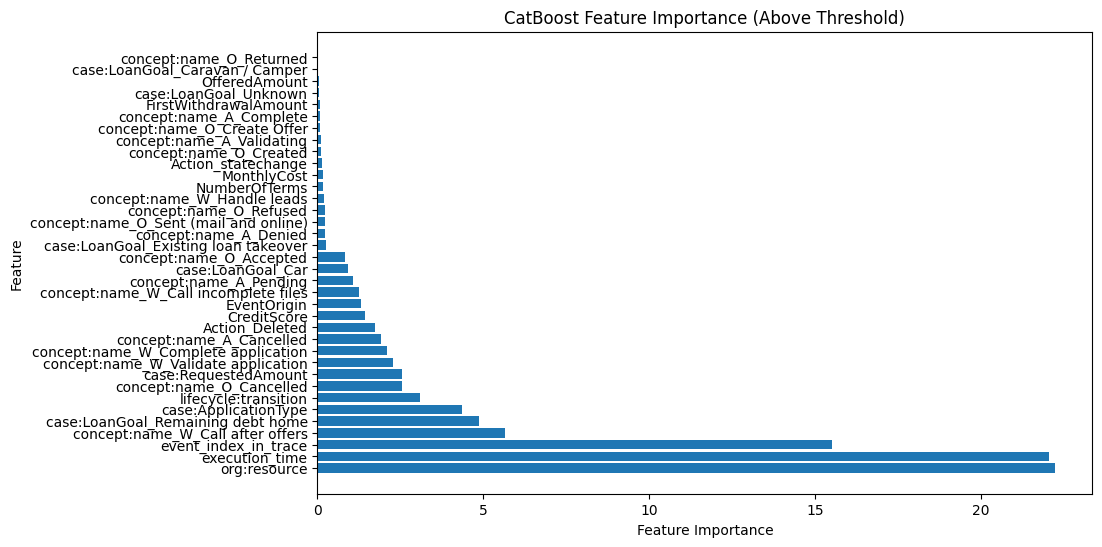

In [21]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Set the threshold for visibility
threshold = 0.01  # Adjust this threshold as needed

# Filter features based on the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Sort the DataFrame by importance in descending order
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot feature importance for only the relevant features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Above Threshold)')
plt.show()
